In [ ]:
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\ADAPT\\ADAPT codebase\\')
import src.config as config
import src.power as power
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.style.use('seaborn-v0_8-notebook')  # notebook-optimized

n_trials = 500
sample = 300
samples = np.arange(20, 110, 10).tolist() + np.arange(120, 320, 20).tolist()

# CGR MoE vs sample size

In [2]:
### Generate CGR data
df_patientsData=[]
for cgr in np.arange(0.5, 1, 0.1):
    cgr = round(cgr, 2)
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'CGR {cgr}', 
            n_trials = n_trials, 
            sample = sample, 
            params = [{
                'type': 'binaryguess',
                'arm_params':{
                    'C': {'cgr': cgr,},
                    'T': {'cgr': cgr,},},}]))

df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData = df_patientsData.rename(columns={'value': 'cgr',})    

# Calculate CIs
df_CIs = power.Stats.get_df_cgrCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples,) 
df_CIs = power.Stats.add_sigdiff(df_CIs)
df_CIs.head(3)

,scenario,trial,sample,cgr,cgr_ciL,cgr_ciH,cgr_moe,cgr_sigdiff
0,CGR 0.5,0,20,0.400,0.191,0.639,0.224,False
1,CGR 0.5,0,30,0.367,0.199,0.561,0.181,False
2,CGR 0.5,0,40,0.475,0.315,0.639,0.162,False


In [3]:
### Calculate avg across trials
rows = []
scenarios = df_CIs.scenario.unique()
samples = df_CIs['sample'].unique()

for scenario, sample in product(scenarios, samples):

    df_tmp = df_CIs.loc[
        (df_CIs.scenario==scenario) & 
        (df_CIs['sample']==sample)]

    rows.append({
        'scenario': scenario,
        'sample': sample, 
        'cgr': df_tmp.cgr.mean(),
        'cgr_ciL': df_tmp.cgr_ciL.mean(),
        'cgr_ciH': df_tmp.cgr_ciH.mean(),
        'cgr_moe': df_tmp.cgr_moe.mean(),})    

df_mean_CIs = pd.DataFrame(rows)
df_mean_CIs.head(3)

,scenario,sample,cgr,cgr_ciL,cgr_ciH,cgr_moe
0,CGR 0.5,20,0.505500,0.281718,0.727574,0.222926
1,CGR 0.5,30,0.500136,0.316000,0.684238,0.184324
2,CGR 0.5,40,0.500100,0.340068,0.660114,0.159884


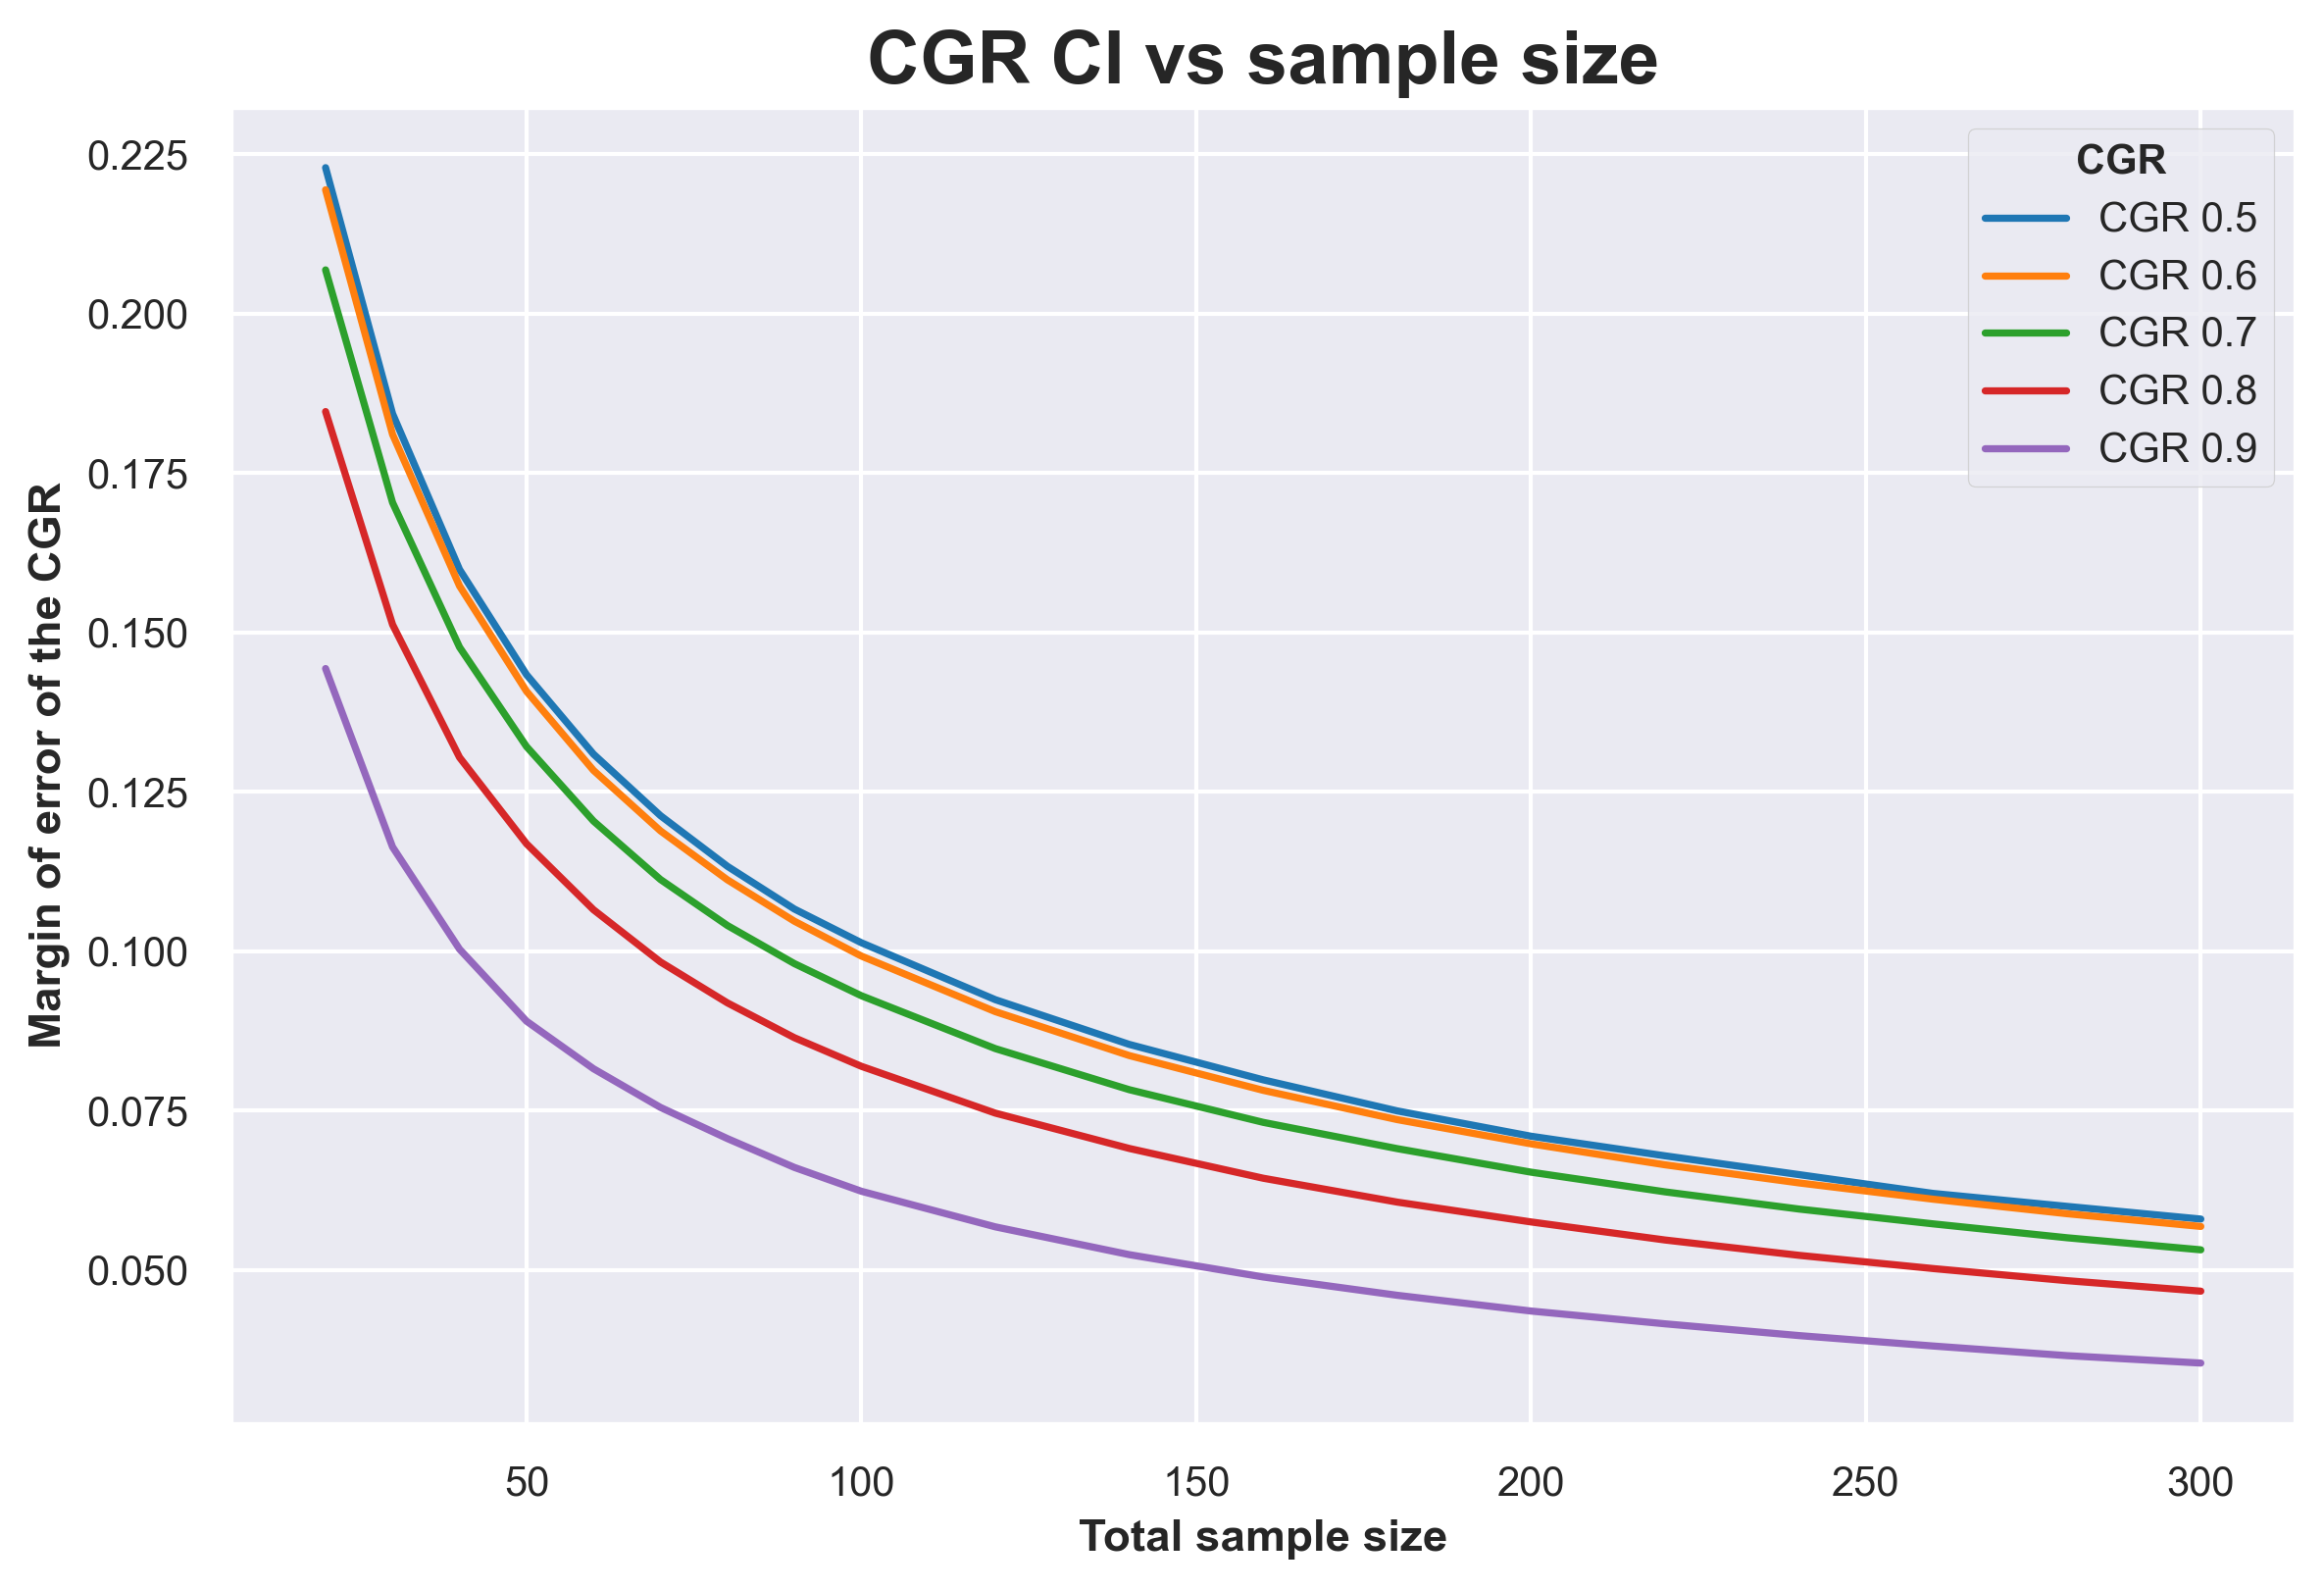

In [4]:
### Plot results
fig, ax = plt.subplots()
sns.lineplot(
    data = df_mean_CIs,
    x = 'sample', 
    y = 'cgr_moe',
    hue = 'scenario',
)

plt.title('CGR CI vs sample size',  fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Margin of error of the CGR', fontweight='bold')
ax.tick_params(axis='both')
plt.tight_layout()
plt.legend(
    title='CGR', 
    title_fontproperties = {'weight': 'bold'},)
power.Helpers.save_fig(fig, 'cgrCI_vs_sample')
plt.show()